# Analyze the performance of the best model
Considering that the logistic regression outperformed the other models, and the version with the network feature generalize better with respect to the one-hot encoding one, we take it as best model (logistic regression with network feature).

In [1]:
import joblib as jl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import maxabs_scale

## Load model and Dataset

In [2]:
# Load the models
modelPath = "../models/log_reg_mix.joblib"
model = jl.load(modelPath)

dataPath = "../features/LR_mix_full_data.npz"
data = np.load(dataPath)


# Load the data
path = "../features/"
data_names = ["symptoms", "betweenness", "community_count", "community_size"]

symptoms = np.load(path + data_names[0] + ".npz")
betweenness = np.load(path + data_names[1] + ".npz")
community_count = np.load(path + data_names[2] + ".npz")
community_size = np.load(path + data_names[3] + ".npz")
data_mix = np.concatenate(
    (
        betweenness["X"],
        community_count["X"],
        community_size["X"],
        community_count["y"].reshape(symptoms["y"].shape[0], 1),
    ),
    axis=1,
)

data_norm = maxabs_scale(data_mix[:, :-1])
data = np.concatenate(
    (data_norm, data_mix[:, -1].reshape(data_mix[:, -1].shape[0], 1)), axis=1
)

x = data[:, :-1]
y = data[:, -1].astype(int)

In [3]:
print(y.min())
print(y.max())
print(len(y))
print(len(np.unique(y)))

0
772
246914
748


## Create a 'Mapping' dataframe

In [4]:
diseases_info = pd.read_csv("../../../dataset/diseases_complete_info.csv")
all_diseases = pd.read_csv("../../../dataset/disease_label_mapping.csv")

y_df = pd.DataFrame(y, columns=["Disease_num"])

tmp=pd.merge(y_df, all_diseases, on="Disease_num")

print(len(tmp["Disease"].unique()))

complete_df = pd.merge(tmp, diseases_info, on="Disease")
print(complete_df)

748
        Disease_num                 Disease  Degree         L2  Class
0               512  fetal alcohol syndrome     5.0  33.400000      1
1               512  fetal alcohol syndrome     5.0  33.400000      1
2               512  fetal alcohol syndrome     5.0  33.400000      1
3               512  fetal alcohol syndrome     5.0  33.400000      1
4               512  fetal alcohol syndrome     5.0  33.400000      1
...             ...                     ...     ...        ...    ...
235641          677  injury to the shoulder    11.0  46.090909      3
235642          677  injury to the shoulder    11.0  46.090909      3
235643          677  injury to the shoulder    11.0  46.090909      3
235644          677  injury to the shoulder    11.0  46.090909      3
235645          677  injury to the shoulder    11.0  46.090909      3

[235646 rows x 5 columns]


## Identify missing diseases and remove it from the dataset

In [5]:
missing_disease = []
for i in all_diseases["Disease_num"].unique():
    if i not in complete_df["Disease_num"].unique():
        missing_disease.append(i)

print(len(missing_disease))
print(missing_disease)


mask = ~np.isin(data[:, -1].astype(int), missing_disease)
new_data = data[mask]

x = new_data[:, :-1]
y = new_data[:, -1].astype(int)

y_df = pd.DataFrame(y, columns=["Disease_num"])

tmp = pd.merge(y_df, all_diseases, on="Disease_num")

print(len(tmp["Disease"].unique()))
print(x.shape, y.shape)
complete_df = pd.merge(tmp, diseases_info, on="Disease")
print(complete_df)

49
[12, 32, 34, 47, 57, 58, 80, 95, 111, 115, 131, 138, 141, 154, 155, 157, 158, 162, 181, 287, 292, 300, 314, 316, 334, 340, 376, 377, 388, 397, 404, 419, 424, 450, 463, 534, 561, 565, 591, 599, 607, 621, 650, 667, 702, 705, 747, 758, 767]
724
(235646, 653) (235646,)
        Disease_num                 Disease  Degree         L2  Class
0               512  fetal alcohol syndrome     5.0  33.400000      1
1               512  fetal alcohol syndrome     5.0  33.400000      1
2               512  fetal alcohol syndrome     5.0  33.400000      1
3               512  fetal alcohol syndrome     5.0  33.400000      1
4               512  fetal alcohol syndrome     5.0  33.400000      1
...             ...                     ...     ...        ...    ...
235641          677  injury to the shoulder    11.0  46.090909      3
235642          677  injury to the shoulder    11.0  46.090909      3
235643          677  injury to the shoulder    11.0  46.090909      3
235644          677  injury to 

In [6]:
y_class = np.array(complete_df["Class"].astype(int))


pred = model.predict(x)

pred_df = pd.DataFrame(y, columns=["Disease_num"])
tmp = pd.merge(pred_df, all_diseases, on="Disease_num")

print(len(tmp["Disease"].unique()))
print(x.shape, y.shape)
complete_df_pred = pd.merge(tmp, diseases_info, on="Disease")

pred_class = np.array(complete_df_pred["Class"].astype(int))

724
(235646, 653) (235646,)


<Axes: >

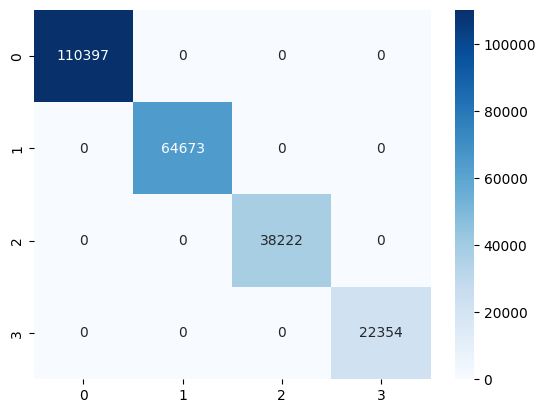

In [8]:
conf_matrix = confusion_matrix(y, pred)

sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=True,
)